<a href="https://colab.research.google.com/github/marcello-grati/capstone_L01_artificial_music_detection/blob/main/Capstone_L01_RvF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import librosa.display
import soundfile
import random
import os, glob
import math
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, matthews_corrcoef

In [ ]:
# import dataset from google drive folder

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Definition of the paths of the datsets #

#Fake data sets paths
pathRiffusionDataset  = '/content/drive/My Drive/capstone_project/Datasets_5/Fake/Riffusion'
pathJSFCDataset  = '/content/drive/My Drive/capstone_project/Datasets_5/Fake/JsFakeChorale'
pathLADataset = '/content/drive/My Drive/capstone_project/Datasets_5/Fake/LA_composer'
pathRNNDataset = '/content/drive/My Drive/capstone_project/Datasets_5/Fake/RNNCPAC'
pathASGenerator = '/content/drive/My Drive/capstone_project/Datasets_5/Fake/ArtificialSongGenerator'

#Real data sets paths
pathMusicnetDataset = '/content/drive/My Drive/capstone_project/Datasets_5/Real/Musicnet'
pathMaestroDataset = '/content/drive/My Drive/capstone_project/Datasets_5/Real/Maestro'

In [ ]:
# Global variables

sr = 16000        # sample rate
n_mels = 128      # number of Mel bands to generate 128
SNR = -20 # [dB]  # Signal to Noise Ratio
num_of_reals = 2  # number of real datasets
num_of_fakes = 5  # number of fake datasets

# File names prefixes

riffusion_id = '01_riffusion_'
js_fake_chorale_id = '01_JsFakeChorale_'
la_composer_id = '01_LA_composer_'
rnn_id = '01_RNN_'
a_s_generator_id = '01_ArtificialSongGenerator_'

musicnet_id = '00_musicnet_'
maestro_id = '00_maestro_'

In [ ]:
# Given a signal and desired SNR, this gives the required AWGN that should be added to the signal to get the desired SNR

def get_white_noise(signal,SNR) :

  RMS_s=math.sqrt(np.mean(signal**2))
  RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
  STD_n=RMS_n
  noise=np.random.normal(0, STD_n, signal.shape[0])

  return noise

In [ ]:
# Feature extraction

def get_features(file, sample_rate, feature_type, noisy=False) :

     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")

        # apply noise to sound wave
        if noisy :
          noise = get_white_noise(waveform, SNR)
          waveform = waveform + noise

        # normalization
        mean = np.mean(waveform, axis=0)
        std = np.std(waveform, axis=0)

        epsilon = 1e-8
        std = np.where(std == 0, epsilon, std)

        waveform = (waveform - mean) / std

        # feature choice
        if feature_type == "mel" :
          return librosa.amplitude_to_db(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=n_mels, fmax=sr/2))

        elif feature_type == "mfc" :
          return librosa.amplitude_to_db(librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=n_mels))

        elif feature_type == "ber":
          return librosa.amplitude_to_db(librosa.feature.spectral_contrast(y=waveform, sr=sample_rate))

        elif feature_type == "stft":
          return librosa.amplitude_to_db(np.abs(librosa.stft(y=waveform)),ref=np.max)

        else :
          print("Wrong feature type")

In [ ]:
#Labels

emotions = {
    'real':'Real',
    'fake':'Fake'
}

In [ ]:
# Splits file name and labels it

def parse_string(input_string,val):
  a = None
  parts = input_string.split('_')
  a = parts[val]

  if(a=='00'):
    return "real"
  elif(a=='01'):
    return "fake"
  else:
    return None

# Takes n unrepeated numbers from 0 to Nmax and return an array of them

def random_int_array(n, Nmax):
  if n > Nmax:
    raise ValueError("n must be less than or equal to Nmax")
  integers = random.sample(range(Nmax), n)
  return np.array(integers)

In [ ]:
# takes audio data from files in datasets and extract their audio features.
# returns:
#   - X : feature matrix
#   - y : labels vector
#   - z : files names vector

def load_data_balanced(num_vector, datasets_vector, feature_type):

  if (len(num_vector) != len(datasets_vector)) :
    print("wrong number of parameters")
    return None

  X, y, z = [],[],[]

  # For all the datasets
  for i in range(len(num_vector)):

    count = 0
    print(datasets_vector[i])

    file = os.listdir(datasets_vector[i])
    # Count the number of songs into the dataset
    songs = len(file)

    # Select random number of songs in the dataset

    print("Number of audio files: " + str(songs))
    chosen_files = random_int_array(num_vector[i], songs)

    #For all the file in the dataset

    for k in chosen_files :

      features = get_features(datasets_vector[i] + '/' + file[k], sr, feature_type)
      emotion = parse_string(file[k],0)

      X.append(features)
      y.append(emotion)
      z.append(file[k])

      count += 1
      print('\r' + f' Processed {count}/{num_vector[i]} audio samples',end=' ')


    print("\n-----------------------------------------------------------------------------------------------------------")

  print("DONE!!!")
  return X, y, z

In [ ]:
# define chosen number of audio files per datasets (sum between real and fake must be equal)

open_test_dim = 300   # all dimensions multiple of this number, just change this

num_samples_vector = [open_test_dim,
                      open_test_dim,
                      open_test_dim,
                      open_test_dim,
                      open_test_dim,
                      4 * open_test_dim,
                      4 * open_test_dim,]

# define path for chosen datasets

datasets_vector = [pathRiffusionDataset,
                   pathJSFCDataset,
                   pathLADataset,
                   pathRNNDataset,
                   pathASGenerator,
                   pathMusicnetDataset,
                   pathMaestroDataset]

# choose feature

feature_type = "mfc"

X, y, z = load_data_balanced(num_samples_vector, datasets_vector, feature_type)

# len(X), len(y), len(z)

/content/drive/My Drive/capstone_project/Datasets_5/Fake/Riffusion
Number of audio files: 500
 Processed 300/300 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/JsFakeChorale
Number of audio files: 528
 Processed 300/300 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/LA_composer
Number of audio files: 488
 Processed 300/300 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/RNNCPAC
Number of audio files: 482
 Processed 300/300 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/

In [ ]:
# dimension test

X[random.randint(0, 10 * open_test_dim - 1)].shape

(128, 157)

In [ ]:
# Fix out of shape songs by truncating or zero-padding

size_number = 157  # expected shape

counter = 0

for index in range(len(X)) :
  if X[index].shape[1] != size_number:
    # print(f"index = {index}, shape = {X[index].shape},  {z[index]}")
    counter += 1

    if (X[index].shape[1] < size_number) :
      X[index] = np.pad(X[index], [(0,0), (0, size_number - X[index].shape[1])])
    X[index] = X[index][:,:size_number]

print(f"\nnumber out of shape songs = {counter}")

X = np.array(X)
y = np.array(y)
z = np.array(z)


number out of shape songs = 19


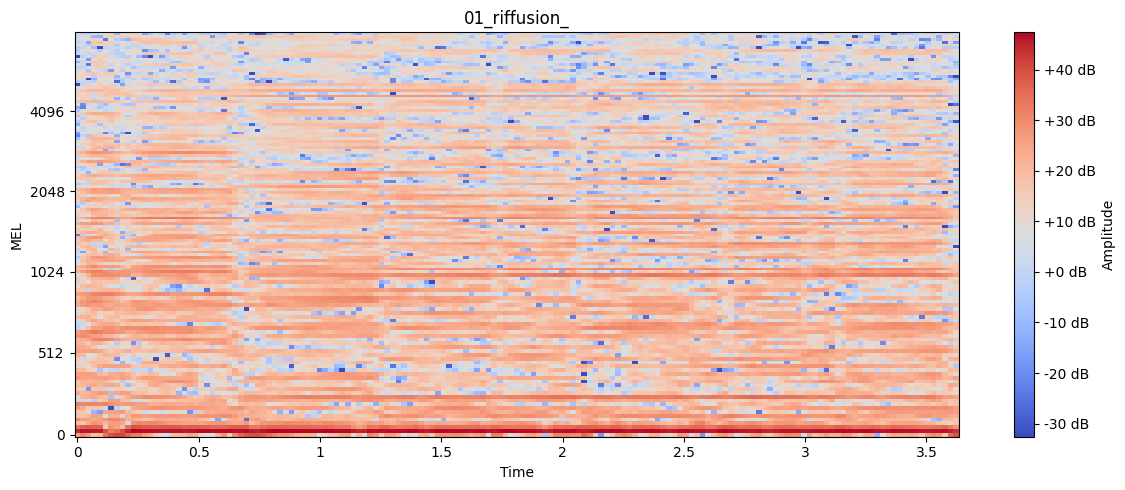

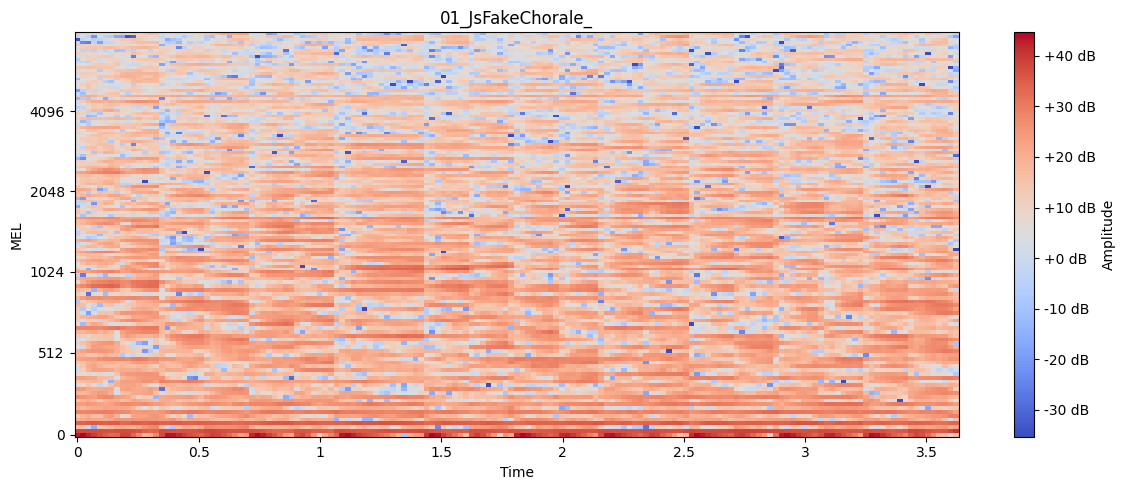

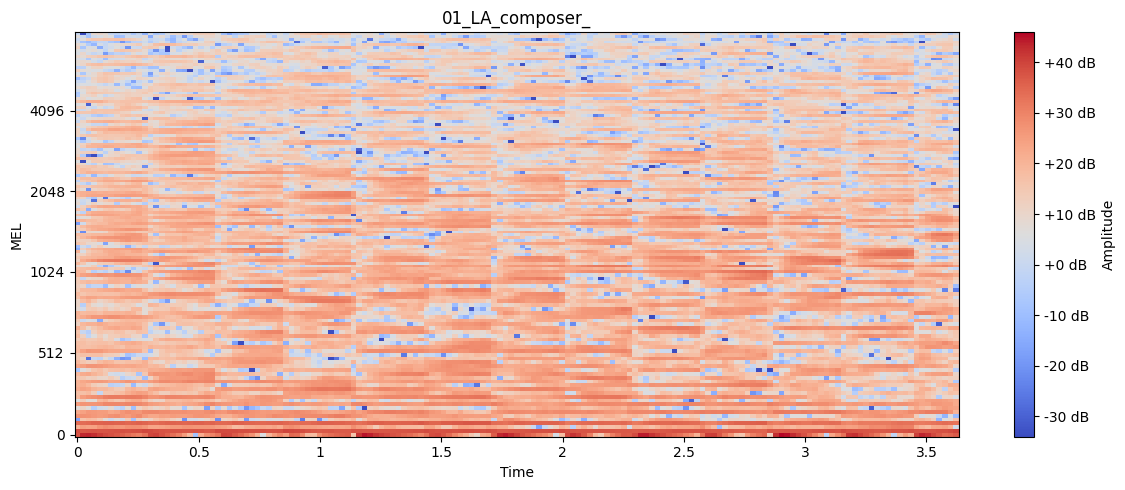

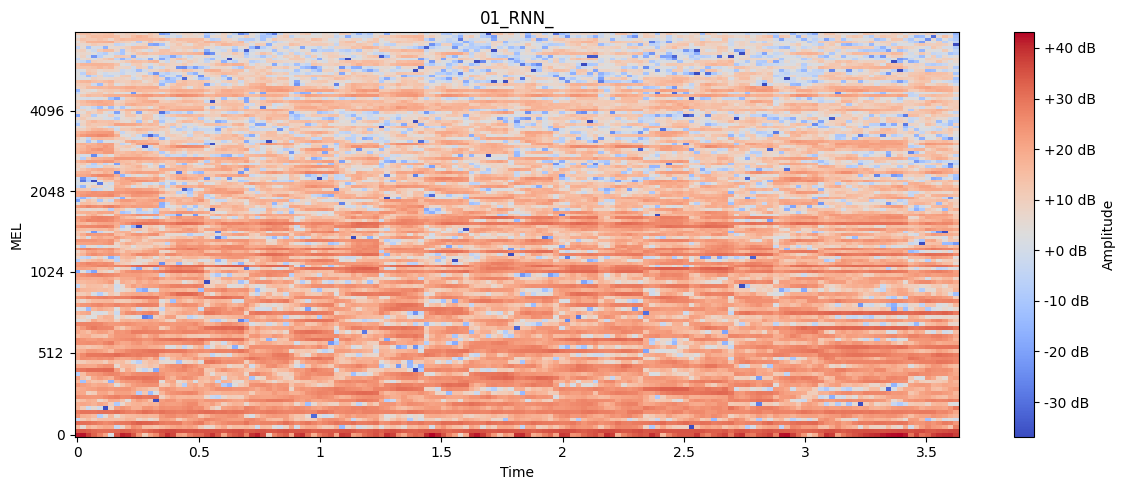

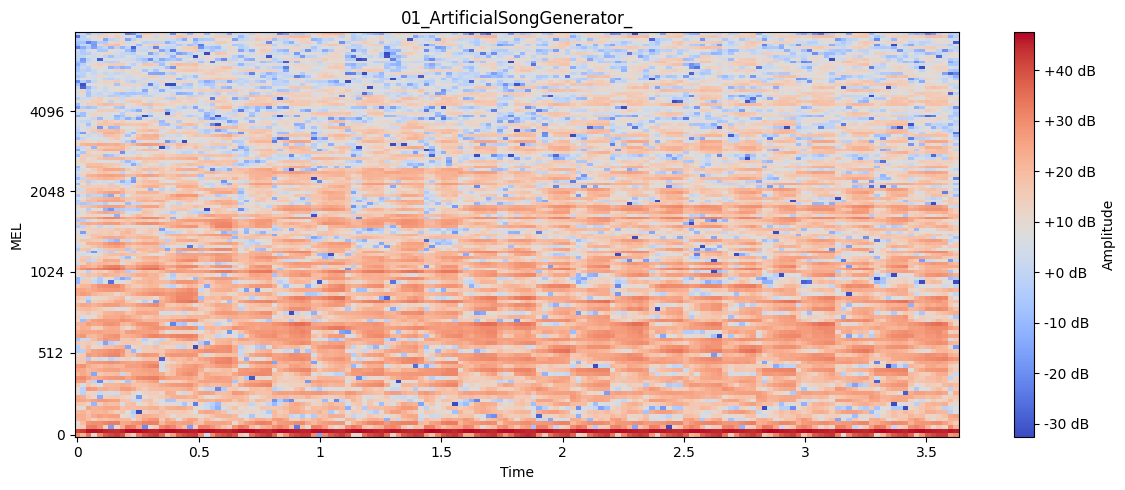

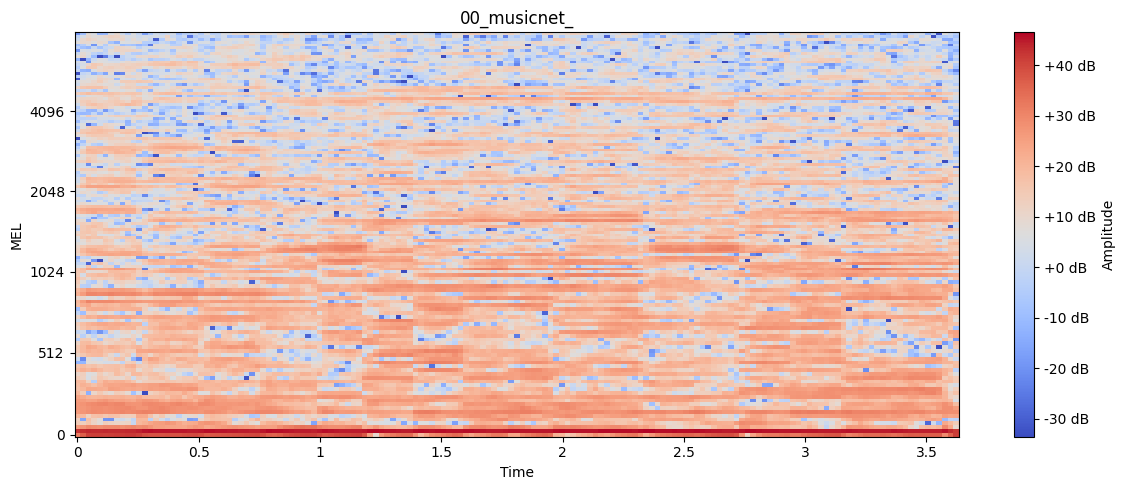

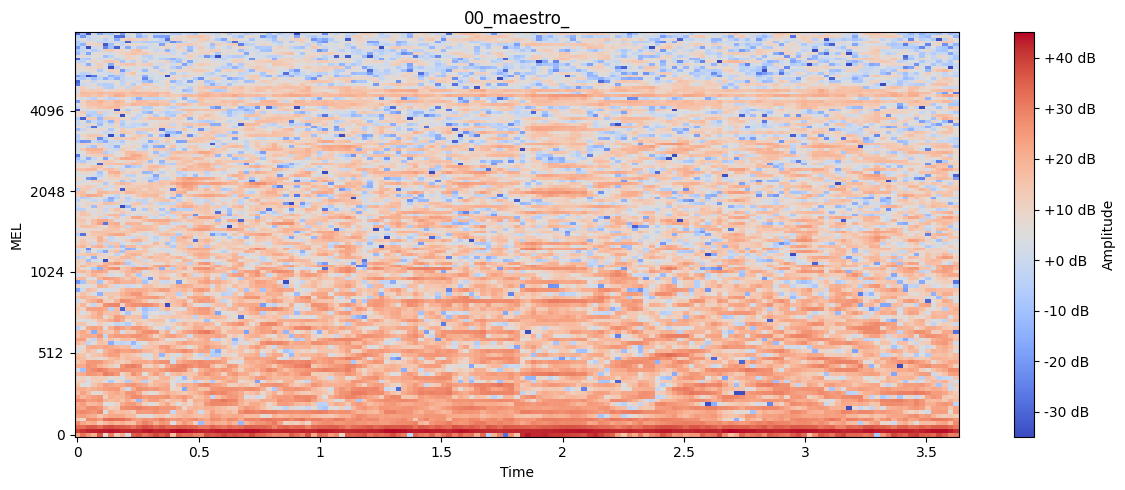

In [ ]:
# Sorts one song for each dataset and print its spectrogram

dataset_names = [riffusion_id,
                 js_fake_chorale_id,
                 la_composer_id,
                 rnn_id,
                 a_s_generator_id,
                 musicnet_id,
                 maestro_id
                 ]

for dataset_index in range(len(dataset_names)):

  current_dataset = []

  for index in range(len(X)) :
    if z[index].startswith(dataset_names[dataset_index]) :
      current_dataset.append(X[index])

  example_number = random.randint(0, len(current_dataset)-1)
  dataset_example = current_dataset[example_number]

  plt.figure(figsize=(12, 5))

  if feature_type == "mel" or feature_type == "mfc" :
    librosa.display.specshow(dataset_example, y_axis='mel',fmax=sr/2, x_axis='time')
    plt.ylabel('MEL')
  else :
    librosa.display.specshow(dataset_example, y_axis='log',fmax=sr/2, x_axis='time')
    plt.ylabel('STFT')
  plt.colorbar(format='%+2.0f dB',label='Amplitude')
  plt.title(dataset_names[dataset_index])
  plt.tight_layout()

In [ ]:
# reshape 3d vector into 2d vector

X_flattened = np.reshape(X, (X.shape[0], -1))

X_flattened.shape

(3900, 20096)

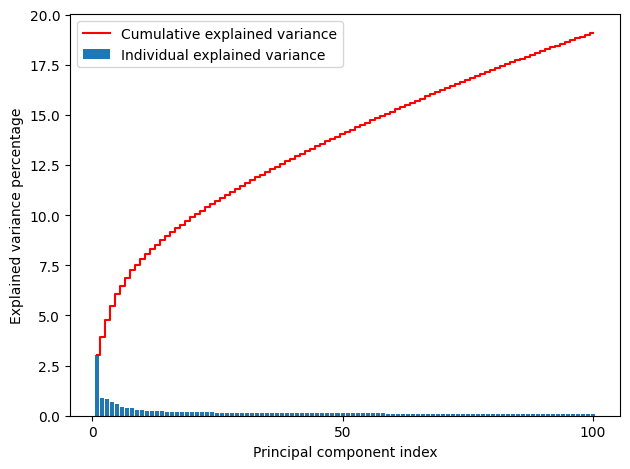

In [ ]:
# apply PCA and evaluate explained variance

n_components = 100

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_flattened)

exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

plt.bar(range(1, n_components+1), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(1, n_components+1), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(0, n_components+1, 50)))
plt.legend(loc='best')
plt.tight_layout()

plt.savefig("Barplot_PCA.png")

In [ ]:
# Creates two subsets, one for close testing and one for open testing

def split_train_from_open(X_pca, y, excluded_fake, excluded_real) :

  X_ready = []
  X_open = []
  y_ready = []
  y_open = []

  counter = 0

  for index in range(len(X_pca)):

    if z[index].startswith(excluded_fake) :
      X_open.append(X_pca[index])
      y_open.append(y[index])

    elif z[index].startswith(excluded_real) :
      if counter < open_test_dim :
        X_open.append(X_pca[index])
        y_open.append(y[index])
        counter+=1

    else :
      X_ready.append(X_pca[index])
      y_ready.append(y[index])

  return np.array(X_ready), np.array(X_open), np.array(y_ready), np.array(y_open)

In [ ]:
# Close Test

def close_test(X_train, y_train, X_test, y_test, classification_models) :

  scores = []
  for model in classification_models:
      model.fit(X_train, y_train)
      score = model.score(X_test, y_test)
      model_name = type(model).__name__
      if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
      y_pred = model.predict(X_test)
      scores.append((
        model_name,
        (f'{100*f1_score(y_test, y_pred, average="macro"):.2f}%'),
        (f'{100*score:.2f}%'),
        (f'{100*matthews_corrcoef(y_test, y_pred):.2f}%'),
        (f'{100*precision_score(y_test, y_pred, average="macro"):.2f}%'),
        (f'{100*recall_score(y_test, y_pred, average="macro"):.2f}%'),
        ))

  scores_df = pd.DataFrame(scores,columns=['Classifier','F1 Score','Accuracy','MCC','Precision','Recall'])

  results = scores_df.sort_values(by='F1 Score',axis=0,ascending=False)

  return classification_models, results

In [ ]:
# Open Test

def open_test(X_open, y_open, trained_models) :

  open_scores = []

  for model in trained_models:
    score = model.score(X_open, y_open)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    y_pred = model.predict(X_open)
    open_scores.append((
        model_name,
        (f'{100*f1_score(y_open, y_pred, average="macro"):.4}%'),
        (f'{100*score:.2f}%'),
        (f'{100*matthews_corrcoef(y_open, y_pred):.4}%'),
        (f'{100*precision_score(y_open, y_pred, average="macro"):.3f}%'),
        (f'{100*recall_score(y_open, y_pred, average="macro"):.3f}%'),
        ))

  open_scores_df = pd.DataFrame(open_scores,columns=['Classifier','F1 Score','Accuracy','MCC','Precision','Recall'])
  return open_scores_df.sort_values(by='F1 Score',axis=0,ascending=False)

In [ ]:
# Execute open and close tests with all models

def execute_tests(classification_models, X, y, excluded_fake, excluded_real, split, verbose=True) :

  X_ready, X_open, y_ready, y_open = split_train_from_open(X, y, excluded_fake, excluded_real)

  X_train, X_test, y_train, y_test = train_test_split(X_ready, y_ready, test_size=split, random_state=42)

  trained_models, close_results = close_test(X_train, y_train, X_test, y_test, classification_models)
  best_close = float(close_results.iloc[0]['F1 Score'][0:-1])

  open_results = open_test(X_open, y_open, trained_models)
  best_open = float(open_results.iloc[0]['F1 Score'][0:-1])

  if verbose :
    print("\n" + excluded_real[3 : -1].upper() + " V.S. " + excluded_fake[3 : -1].upper())
    print("\nClose Test")
    display(close_results)
    print("\nOpen Test")
    display(open_results)

  return best_close, best_open


In [ ]:
# Execute all open test combinations

def test_all_open(classification_models, real_dataset_names, fake_dataset_names, split, X_pca, y, verbose=True) :

  f1_results = []

  for i in range(len(real_dataset_names)) :
    for j in range(len(fake_dataset_names)) :

      excluded_real = real_dataset_names[i]
      excluded_fake = fake_dataset_names[j]

      best_close, best_open = execute_tests(classification_models, X_pca, y, excluded_fake, excluded_real, split, verbose)

      f1_results.append([best_close, best_open])

      #print(f"\nClose : {best_close}% --> Open : {best_open}")

  return f1_results

In [ ]:
# Testing

# File name prefixes

riffusion_id = '01_riffusion_'
js_fake_chorale_id = '01_JsFakeChorale_'
la_composer_id = '01_LA_composer_'
rnn_id = '01_RNN_'

musicnet_id = '00_musicnet_'
maestro_id = '00_maestro_'

# Classification models

all_classification_models = [
      KNeighborsClassifier(),#(3),
      SVC(kernel='linear'),# C=0.025),
      DecisionTreeClassifier(),#max_depth=5),
      RandomForestClassifier(max_features=None),#max_depth=5, n_estimators=10, max_features=1),
      AdaBoostClassifier(),
      GaussianNB(),
      QuadraticDiscriminantAnalysis(),
      SVC(kernel='rbf')
      ]

# Datsets

real_dataset_names = [musicnet_id,
                      maestro_id]

fake_dataset_names = [riffusion_id,
                      js_fake_chorale_id,
                      la_composer_id,
                      rnn_id,
                      a_s_generator_id]

# Train/test split
split = 0.2

# Chosen models
classification_models = [RandomForestClassifier(max_features=None)]

f1_results = test_all_open(all_classification_models, real_dataset_names, fake_dataset_names, split, X_pca, y)


MUSICNET V.S. RIFFUSION


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
3,RandomForestClassifier,92.66%,92.67%,85.56%,92.897%,92.667%
2,DecisionTreeClassifier,92.49%,92.50%,85.21%,92.709%,92.500%
4,AdaBoostClassifier,88.37%,88.50%,78.76%,90.276%,88.500%
5,GaussianNB,87.5%,87.50%,75.0%,87.504%,87.500%
7,SVC RBF kernel,64.97%,68.33%,46.73%,79.781%,68.333%
0,KNeighborsClassifier,59.7%,64.50%,40.07%,77.677%,64.500%
1,SVC,41.8%,53.50%,15.81%,67.858%,53.500%
6,QuadraticDiscriminantAnalysis,36.59%,50.50%,2.855%,54.076%,50.500%



MUSICNET V.S. JSFAKECHORALE


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,KNeighborsClassifier,99.33%,99.33%,98.68%,99.342%,99.333%
4,AdaBoostClassifier,98.67%,98.67%,97.35%,98.686%,98.667%
7,SVC RBF kernel,98.5%,98.50%,97.04%,98.544%,98.500%
3,RandomForestClassifier,97.5%,97.50%,95.04%,97.543%,97.500%
2,DecisionTreeClassifier,93.32%,93.33%,86.9%,93.568%,93.333%
5,GaussianNB,91.65%,91.67%,83.75%,92.088%,91.667%
1,SVC,91.48%,91.50%,83.45%,91.948%,91.500%
6,QuadraticDiscriminantAnalysis,91.12%,91.17%,83.28%,92.114%,91.167%



MUSICNET V.S. LA_COMPOSER


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
1,SVC,93.14%,93.17%,87.07%,93.909%,93.167%
6,QuadraticDiscriminantAnalysis,91.14%,91.17%,82.84%,91.671%,91.167%
7,SVC RBF kernel,90.79%,90.83%,82.52%,91.690%,90.833%
0,KNeighborsClassifier,90.6%,90.67%,82.49%,91.829%,90.667%
3,RandomForestClassifier,90.1%,90.17%,81.52%,91.362%,90.167%
4,AdaBoostClassifier,89.09%,89.17%,79.4%,90.240%,89.167%
2,DecisionTreeClassifier,86.28%,86.33%,73.2%,86.864%,86.333%
5,GaussianNB,78.61%,78.83%,58.9%,80.077%,78.833%



MUSICNET V.S. RNN


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,KNeighborsClassifier,98.67%,98.67%,97.35%,98.686%,98.667%
3,RandomForestClassifier,97.83%,97.83%,95.71%,97.876%,97.833%
7,SVC RBF kernel,97.67%,97.67%,95.35%,97.686%,97.667%
4,AdaBoostClassifier,97.5%,97.50%,95.04%,97.543%,97.500%
2,DecisionTreeClassifier,92.98%,93.00%,86.43%,93.434%,93.000%
5,GaussianNB,92.97%,93.00%,86.7%,93.701%,93.000%
6,QuadraticDiscriminantAnalysis,91.44%,91.50%,84.23%,92.735%,91.500%
1,SVC,88.83%,88.83%,77.76%,88.931%,88.833%



MUSICNET V.S. ARTIFICIALSONGGENERATOR


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
3,RandomForestClassifier,82.85%,83.17%,68.89%,85.775%,83.167%
5,GaussianNB,81.46%,81.67%,64.83%,83.177%,81.667%
2,DecisionTreeClassifier,81.31%,81.50%,64.34%,82.859%,81.500%
7,SVC RBF kernel,79.75%,80.33%,64.51%,84.298%,80.333%
4,AdaBoostClassifier,79.36%,80.00%,64.14%,84.280%,80.000%
0,KNeighborsClassifier,75.75%,76.83%,59.24%,82.692%,76.833%
1,SVC,64.07%,66.17%,36.93%,71.095%,66.167%
6,QuadraticDiscriminantAnalysis,44.9%,53.50%,11.42%,59.311%,53.500%



MAESTRO V.S. RIFFUSION


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
2,DecisionTreeClassifier,92.16%,92.17%,84.37%,92.205%,92.167%
3,RandomForestClassifier,92.16%,92.17%,84.44%,92.272%,92.167%
4,AdaBoostClassifier,90.96%,91.00%,82.74%,91.742%,91.000%
5,GaussianNB,75.77%,76.00%,53.0%,77.010%,76.000%
7,SVC RBF kernel,75.17%,76.33%,58.44%,82.421%,76.333%
0,KNeighborsClassifier,64.97%,68.33%,46.73%,79.781%,68.333%
1,SVC,48.13%,55.17%,15.28%,61.298%,55.167%
6,QuadraticDiscriminantAnalysis,38.39%,52.00%,11.72%,67.182%,52.000%



MAESTRO V.S. JSFAKECHORALE


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,KNeighborsClassifier,99.5%,99.50%,99.0%,99.505%,99.500%
3,RandomForestClassifier,96.66%,96.67%,93.5%,96.835%,96.667%
4,AdaBoostClassifier,96.66%,96.67%,93.5%,96.835%,96.667%
7,SVC RBF kernel,95.99%,96.00%,92.3%,96.296%,96.000%
2,DecisionTreeClassifier,95.33%,95.33%,90.96%,95.625%,95.333%
6,QuadraticDiscriminantAnalysis,95.32%,95.33%,91.06%,95.732%,95.333%
1,SVC,87.65%,87.83%,78.01%,90.214%,87.833%
5,GaussianNB,84.15%,84.50%,72.25%,87.829%,84.500%



MAESTRO V.S. LA_COMPOSER


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
6,QuadraticDiscriminantAnalysis,92.66%,92.67%,85.45%,92.788%,92.667%
0,KNeighborsClassifier,91.78%,91.83%,84.71%,92.886%,91.833%
3,RandomForestClassifier,90.13%,90.17%,80.89%,90.721%,90.167%
2,DecisionTreeClassifier,88.45%,88.50%,77.66%,89.162%,88.500%
7,SVC RBF kernel,87.63%,87.67%,75.77%,88.100%,87.667%
4,AdaBoostClassifier,86.93%,87.00%,74.81%,87.813%,87.000%
1,SVC,84.21%,84.33%,69.72%,85.397%,84.333%
5,GaussianNB,65.29%,65.33%,30.74%,65.402%,65.333%



MAESTRO V.S. RNN


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,KNeighborsClassifier,99.33%,99.33%,98.67%,99.336%,99.333%
4,AdaBoostClassifier,97.17%,97.17%,94.38%,97.209%,97.167%
3,RandomForestClassifier,97.0%,97.00%,94.13%,97.134%,97.000%
7,SVC RBF kernel,95.49%,95.50%,91.32%,95.818%,95.500%
2,DecisionTreeClassifier,95.33%,95.33%,90.87%,95.536%,95.333%
6,QuadraticDiscriminantAnalysis,93.47%,93.50%,87.74%,94.248%,93.500%
1,SVC,86.87%,87.00%,75.53%,88.542%,87.000%
5,GaussianNB,82.41%,82.83%,69.07%,86.324%,82.833%



MAESTRO V.S. ARTIFICIALSONGGENERATOR


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
3,RandomForestClassifier,83.62%,83.83%,69.53%,85.723%,83.833%
2,DecisionTreeClassifier,83.38%,83.50%,67.99%,84.497%,83.500%
7,SVC RBF kernel,82.19%,82.50%,67.38%,84.922%,82.500%
4,AdaBoostClassifier,79.22%,79.83%,63.53%,83.820%,79.833%
0,KNeighborsClassifier,77.52%,78.50%,62.7%,84.487%,78.500%
1,SVC,77.03%,77.17%,55.01%,77.850%,77.167%
5,GaussianNB,74.33%,74.33%,48.68%,74.351%,74.333%
6,QuadraticDiscriminantAnalysis,43.37%,54.33%,18.25%,69.208%,54.333%


In [ ]:
# Repeats test with different numbers of PCA components

split = 0.2
classification_models = [RandomForestClassifier(max_features=None)]

parameters = range(100, 3000, 400)
pca_results = []

for n_components in parameters :
  pca = PCA(n_components=n_components)
  X_pca = pca.fit_transform(X_flattened)

  f1_results = test_all_open(classification_models, real_dataset_names, fake_dataset_names, split, X_pca, y, verbose=False)
  f1_mean_results = np.mean(np.array(f1_results), 0)
  pca_results.append(f1_mean_results)

  print(f"\nPCA = {n_components}  \t| Close : {f1_mean_results[0]:.4}%  \t--> Open : {f1_mean_results[1]:.4}%")

pca_results = np.array(pca_results)

plt.plot(parameters, pca_results[:,0], 'g', label='close')
plt.plot(parameters, pca_results[:,1], 'b', label='open')
plt.title('F1 score with respect to number of PCA components')
plt.xlabel('components')
plt.ylabel('F1 score')
plt.legend()
plt.show()
plt.savefig("PCA influence.png")

' # PCA testing\n\nsplit = 0.2\nclassification_models = [RandomForestClassifier(max_features=None)]\n\nparameters = range(100, 3000, 400)\npca_results = []\n\nfor n_components in parameters :\n  pca = PCA(n_components=n_components)\n  X_pca = pca.fit_transform(X_flattened)\n\n  f1_results = test_all_open(classification_models, real_dataset_names, fake_dataset_names, split, X_pca, y, verbose=False)\n  f1_mean_results = np.mean(np.array(f1_results), 0)\n  pca_results.append(f1_mean_results)\n\n  print(f"\nPCA = {n_components}  \t| Close : {f1_mean_results[0]:.4}%  \t--> Open : {f1_mean_results[1]:.4}%")\n\npca_results = np.array(pca_results)\n\nplt.plot(parameters, pca_results[:,0], \'g\', label=\'close\')\nplt.plot(parameters, pca_results[:,1], \'b\', label=\'open\')\nplt.title(\'F1 score with respect to number of PCA components\')\nplt.xlabel(\'components\')\nplt.ylabel(\'F1 score\')\nplt.legend()\nplt.show()\nplt.savefig("PCA influence.png") '

In [ ]:
''' # Repeats test with different split values

classification_models = [RandomForestClassifier()]

splits = np.arange(0.99, 0.89, -0.01)
split_results = []

for split in splits :
  f1_results = test_all_open(classification_models, real_dataset_names, fake_dataset_names, split, X_pca, y, verbose=False)
  f1_mean_results = np.mean(np.array(f1_results), 0)
  split_results.append(f1_mean_results)

  print(f"\nsplit = {split:.3}  \t| Close : {f1_mean_results[0]:.4}%  \t--> Open : {f1_mean_results[1]:.4}%")

split_results = np.array(split_results)

plt.plot(splits, split_results[:,0], 'g', label='close')
plt.plot(splits, split_results[:,1], 'b', label='open')
plt.title('F1 score with respect to split between train and test sets')
plt.xlabel('splits')
plt.ylabel('F1 score')
plt.legend()
plt.show()
plt.savefig("Split influence.png") '''

' # Split testing\n\nclassification_models = [RandomForestClassifier()]\n\nsplits = np.arange(0.99, 0.89, -0.01)\nsplit_results = []\n\nfor split in splits :\n  f1_results = test_all_open(classification_models, real_dataset_names, fake_dataset_names, split, X_pca, y, verbose=False)\n  f1_mean_results = np.mean(np.array(f1_results), 0)\n  split_results.append(f1_mean_results)\n\n  print(f"\nsplit = {split:.3}  \t| Close : {f1_mean_results[0]:.4}%  \t--> Open : {f1_mean_results[1]:.4}%")\n\nsplit_results = np.array(split_results)\n\nplt.plot(splits, split_results[:,0], \'g\', label=\'close\')\nplt.plot(splits, split_results[:,1], \'b\', label=\'open\')\nplt.title(\'F1 score with respect to split between train and test sets\')\nplt.xlabel(\'splits\')\nplt.ylabel(\'F1 score\')\nplt.legend()\nplt.show()\nplt.savefig("Split influence.png") '